# Result plots

In [60]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [61]:
def create_3d_numpy_array_with_folder_mapping(base_directory):
    # Define configurations, learning methods, and folders
    configurations = ['multi-step-ahead-direct', 'multi-step-ahead-iterative', 'single-step-ahead']
    learning_methods = ['LSTM', 'RandomForest']

    # Scan the base directory for folders (Z-axis)
    folders = sorted([f for f in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, f))])

    # Initialize the 3D array (Python list first)
    model_3d_array = [[[None for _ in configurations] for _ in learning_methods] for _ in folders]
    folder_mapping = {}

    # Function to load JSON file
    def load_json_file(filepath):
        with open(filepath, 'r') as file:
            return json.load(file)

    # Iterate over the folders (Z-axis)
    for z_idx, folder in enumerate(folders):
        folder_path = os.path.join(base_directory, folder)

        # Map folder name to Z-axis index
        folder_mapping[folder] = z_idx

        # Iterate over the files in each folder
        for filename in os.listdir(folder_path):
            if filename.endswith(".json"):
                # Determine the model type (LSTM or RandomForest) from the filename
                if "LSTM" in filename:
                    y_idx = 0  # LSTM corresponds to Y-axis index 0
                elif "RandomForest" in filename:
                    y_idx = 1  # RandomForest corresponds to Y-axis index 1
                else:
                    continue  # Skip files that don't match the model types

                # Determine the configuration type (X-axis index)
                if "multi-step-ahead-direct" in filename:
                    x_idx = 0
                elif "multi-step-ahead-iterative" in filename:
                    x_idx = 1
                elif "single-step-ahead" in filename:
                    x_idx = 2
                else:
                    continue  # Skip files that don't match the configuration types

                # Load the JSON data and store it in the 3D array
                filepath = os.path.join(folder_path, filename)
                model_3d_array[z_idx][y_idx][x_idx] = load_json_file(filepath)

    # Convert the Python list (3D array) to a NumPy array with dtype=object
    model_3d_numpy_array = np.array(model_3d_array, dtype=object)

    return model_3d_numpy_array, folder_mapping

# Usage example
base_directory = os.getcwd() + "/json"  # Set this to the path where your folders (e.g., balanced_10, hybrid_1, etc.) are located
model_3d_numpy_array, folder_mapping = create_3d_numpy_array_with_folder_mapping(base_directory)

# Print the NumPy array structure and folder mapping to verify
print("3D Model NumPy Array:", model_3d_numpy_array.shape)
for key, value in folder_mapping.items():
    print(key, ":", value)


3D Model NumPy Array: (20, 2, 3)
balanced_10 : 0
balanced_100 : 1
balanced_150 : 2
balanced_50 : 3
hybrid_1 : 4
hybrid_4 : 5
hybrid_9 : 6
split_12_12 : 7
split_18_6 : 8
split_6_6 : 9
split_6_9 : 10
split_9_3 : 11
split_9_6 : 12
unbalanced_10 : 13
unbalanced_100 : 14
unbalanced_25 : 15
unbalanced_5 : 16
unbalanced_50 : 17
with : 18
without : 19


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to plot single-step ahead metric for each subgroup (side-by-side bars for LSTM and Random Forest)
def plot_single_step_comparison(model_3d_numpy_array, folder_mapping, metric='mse'):
    # Define subgroups
    subgroups = {
        'balanced': [],
        'hybrid': [],
        'split': [],
        'unbalanced': []
    }

    # Assign folders to subgroups
    for folder, z_idx in folder_mapping.items():
        if 'unbalanced' in folder or 'without' in folder or 'with' in folder:
            subgroups['unbalanced'].append(z_idx)
        elif 'hybrid' in folder:
            subgroups['hybrid'].append(z_idx)
        elif 'split' in folder:
            subgroups['split'].append(z_idx)
        elif 'balanced' in folder:
            subgroups['balanced'].append(z_idx)

    # Create a folder structure to save the plots if it doesn't exist
    for group in subgroups:
        os.makedirs(f'./plot/{metric}/{group}', exist_ok=True)

    # Plot single-step ahead for each subgroup
    for group, z_indices in subgroups.items():
        if len(z_indices) == 0:  # Skip subgroups with no folders
            continue

        folder_names = [list(folder_mapping.keys())[list(folder_mapping.values()).index(z_idx)] for z_idx in z_indices]
        
        # Prepare the data based on the given metric
        lstm_metric = [model_3d_numpy_array[z_idx, 0, 2][metric][0] for z_idx in z_indices]  # Single-Step-Ahead LSTM
        rf_metric = [model_3d_numpy_array[z_idx, 1, 2][metric][0] for z_idx in z_indices]    # Single-Step-Ahead RF

        # Calculate the minimum value across LSTM and RF to set the lower limit
        all_metrics = np.array(lstm_metric + rf_metric)
        min_metric = all_metrics.min()
        max_metric = all_metrics.max()

        # Set lower and upper y-limits
        y_min = min_metric - (max_metric - min_metric) * 0.05  # Set the lower limit to 5% below the minimum
        y_max = max_metric + (max_metric - min_metric) * 0.05  # Set the upper limit to 1

        # Plot side-by-side bars
        x = np.arange(len(folder_names))  # Folder positions
        width = 0.35  # Width of the bars

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(x - width/2, lstm_metric, width, label=f'LSTM {metric.upper()}', color='cyan')
        ax.bar(x + width/2, rf_metric, width, label=f'Random Forest {metric.upper()}', color='magenta')

        # Set y-axis limits to show the range clearly
        ax.set_ylim(y_min, y_max)

        # Labels and title
        ax.set_xlabel('Folders')
        ax.set_ylabel(metric.upper())
        ax.set_title(f'Single-Step {metric.upper()} Comparison - {group.capitalize()} Configuration')
        ax.set_xticks(x)
        ax.set_xticklabels(folder_names)
        ax.legend()

        # Save the plot to the specified directory
        save_path = f'./plot/{metric}/{group}/{group}_comparison_single.png'
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()  # Close the plot to avoid display

In [17]:
# Usage example
plot_single_step_comparison(model_3d_numpy_array, folder_mapping, metric='mse')
plot_single_step_comparison(model_3d_numpy_array, folder_mapping, metric='mae')
plot_single_step_comparison(model_3d_numpy_array, folder_mapping, metric='rmse')
plot_single_step_comparison(model_3d_numpy_array, folder_mapping, metric='r2')
plot_single_step_comparison(model_3d_numpy_array, folder_mapping, metric='accuracy')
plot_single_step_comparison(model_3d_numpy_array, folder_mapping, metric='precision')
plot_single_step_comparison(model_3d_numpy_array, folder_mapping, metric='recall')
plot_single_step_comparison(model_3d_numpy_array, folder_mapping, metric='f1')

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to generate lighter to medium shades of a base color
def generate_color_shades(base_color, num_shades):
    base_color = np.array(base_color)  # Convert base color to NumPy array
    color_shades = [(base_color * (0.5 + (i / (2 * num_shades)))).tolist() for i in range(num_shades)]  # Limit shading range
    return ['#%02x%02x%02x' % tuple(int(c) for c in shade) for shade in color_shades]

# Function to plot grouped multi-step ahead metrics for each subgroup with color palettes and save the plots
def plot_multi_step_direct_grouped(model_3d_numpy_array, folder_mapping, metric='mse'):
    # Define subgroups
    subgroups = {
        'balanced': [],
        'hybrid': [],
        'split': {},
        'unbalanced': []
    }

    # Assign folders to subgroups
    for folder, z_idx in folder_mapping.items():
        metric_len = len(model_3d_numpy_array[z_idx, 0, 0][metric])  # Get the length of the metric array (number of months)
        
        if 'unbalanced' in folder or 'without' in folder or 'with' in folder:
            subgroups['unbalanced'].append(z_idx)
        elif 'hybrid' in folder:
            subgroups['hybrid'].append(z_idx)
        elif 'split' in folder:
            if metric_len not in subgroups['split']:
                subgroups['split'][metric_len] = []
            subgroups['split'][metric_len].append(z_idx)
        elif 'balanced' in folder:
            subgroups['balanced'].append(z_idx)

    # Create a folder structure to save the plots if it doesn't exist
    for group in subgroups:
        os.makedirs(f'./plot/{metric}/{group}', exist_ok=True)

    # Function to plot each subgroup and save the plot
    def plot_subgroup(z_indices, plot_title, group_name):
        plt.figure(figsize=(10, 6))
        
        num_folders = len(z_indices)

        # Generate lighter to medium shades for LSTM and RF
        lstm_cyan_shades = generate_color_shades([0, 255, 255], num_folders)  # Cyan shades for LSTM
        rf_magenta_shades = generate_color_shades([255, 0, 255], num_folders)  # Magenta shades for RF

        for i, z_idx in enumerate(z_indices):
            folder_name = list(folder_mapping.keys())[list(folder_mapping.values()).index(z_idx)]
            
            # Prepare the data for the given metric
            lstm_metric = model_3d_numpy_array[z_idx, 0, 0][metric]  # Multi-Step-Ahead-Direct LSTM values (list of months)
            rf_metric = model_3d_numpy_array[z_idx, 1, 0][metric]    # Multi-Step-Ahead-Direct Random Forest values (list of months)
            
            months = np.arange(1, len(lstm_metric) + 1)  # Create a list of months based on the number of metric values
            
            # Plot the data for each folder (line plot)
            plt.plot(months, lstm_metric, marker='o', linestyle='-', label=f'{folder_name} LSTM', color=lstm_cyan_shades[i])  # Cyan shades for LSTM
            plt.plot(months, rf_metric, marker='o', linestyle='--', label=f'{folder_name} RF', color=rf_magenta_shades[i])  # Magenta shades for RF
        
        # Labels and title
        plt.xlabel('Month')
        plt.ylabel(metric.upper())
        plt.title(plot_title)
        plt.grid(True)

        # Move the legend below the plot
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

        # Create the directory if it doesn't exist for dynamically created subgroups
        save_dir = f'./plot/{metric}/{group_name}'
        os.makedirs(save_dir, exist_ok=True)

        # Save the plot to the specified directory
        save_path = f'{save_dir}/{group_name}_comparison_multi_direct.png'
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()  # Close the plot to avoid display

    # Plot for Balanced, Hybrid, and Unbalanced subgroups
    for group_name in ['balanced', 'hybrid', 'unbalanced']:
        z_indices = subgroups[group_name]
        if z_indices:
            plot_subgroup(z_indices, f'Multi-Step-Ahead Direct {metric.upper()} Comparison - {group_name.capitalize()} Folders', group_name)
    
    # Plot for Split (grouped by length of metric array)
    for metric_len, z_indices in subgroups['split'].items():
        group_name = f'split_len_{metric_len}'
        plot_subgroup(z_indices, f'Multi-Step-Ahead Direct {metric.upper()} Comparison - Split Folders (Length: {metric_len})', group_name)

In [19]:
# Usage example (to plot RMSE)
plot_multi_step_direct_grouped(model_3d_numpy_array, folder_mapping, metric='mse')
plot_multi_step_direct_grouped(model_3d_numpy_array, folder_mapping, metric='mae')
plot_multi_step_direct_grouped(model_3d_numpy_array, folder_mapping, metric='rmse')
plot_multi_step_direct_grouped(model_3d_numpy_array, folder_mapping, metric='r2')
plot_multi_step_direct_grouped(model_3d_numpy_array, folder_mapping, metric='accuracy')
plot_multi_step_direct_grouped(model_3d_numpy_array, folder_mapping, metric='precision')
plot_multi_step_direct_grouped(model_3d_numpy_array, folder_mapping, metric='recall')
plot_multi_step_direct_grouped(model_3d_numpy_array, folder_mapping, metric='f1')

In [20]:
# Function to plot grouped multi-step ahead metrics for each subgroup with color palettes and save the plots
def plot_multi_step_iterative_grouped(model_3d_numpy_array, folder_mapping, metric='mse'):
    # Define subgroups
    subgroups = {
        'balanced': [],
        'hybrid': [],
        'split': {},
        'unbalanced': []
    }

    # Assign folders to subgroups
    for folder, z_idx in folder_mapping.items():
        metric_len = len(model_3d_numpy_array[z_idx, 0, 0][metric])  # Get the length of the metric array (number of months)
        
        if 'unbalanced' in folder or 'without' in folder  or 'with' in folder:
            subgroups['unbalanced'].append(z_idx)
        elif 'hybrid' in folder:
            subgroups['hybrid'].append(z_idx)
        elif 'split' in folder:
            if metric_len not in subgroups['split']:
                subgroups['split'][metric_len] = []
            subgroups['split'][metric_len].append(z_idx)
        elif 'balanced' in folder:
            subgroups['balanced'].append(z_idx)

    # Create a folder structure to save the plots if it doesn't exist
    for group in subgroups:
        os.makedirs(f'./plot/{metric}/{group}', exist_ok=True)

    # Function to plot each subgroup and save the plot
    def plot_subgroup(z_indices, plot_title, group_name):
        plt.figure(figsize=(10, 6))
        
        num_folders = len(z_indices)

        # Generate lighter to medium shades for LSTM and RF
        lstm_cyan_shades = generate_color_shades([0, 255, 255], num_folders)  # Cyan shades for LSTM
        rf_magenta_shades = generate_color_shades([255, 0, 255], num_folders)  # Magenta shades for RF

        for i, z_idx in enumerate(z_indices):
            folder_name = list(folder_mapping.keys())[list(folder_mapping.values()).index(z_idx)]
            
            # Prepare the data for the given metric
            lstm_metric = model_3d_numpy_array[z_idx, 0, 1][metric]  # Multi-Step-Ahead-Iterative LSTM values (list of months)
            rf_metric = model_3d_numpy_array[z_idx, 1, 1][metric]    # Multi-Step-Ahead-Iterative Random Forest values (list of months)
            
            months = np.arange(1, len(lstm_metric) + 1)  # Create a list of months based on the number of metric values
            
            # Plot the data for each folder (line plot)
            plt.plot(months, lstm_metric, marker='o', linestyle='-', label=f'{folder_name} LSTM', color=lstm_cyan_shades[i])  # Cyan shades for LSTM
            plt.plot(months, rf_metric, marker='o', linestyle='--', label=f'{folder_name} RF', color=rf_magenta_shades[i])  # Magenta shades for RF
        
        # Labels and title
        plt.xlabel('Month')
        plt.ylabel(metric.upper())
        plt.title(plot_title)
        plt.grid(True)

        # Move the legend below the plot
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

        # Create the directory if it doesn't exist for dynamically created subgroups
        save_dir = f'./plot/{metric}/{group_name}'
        os.makedirs(save_dir, exist_ok=True)

        # Save the plot to the specified directory
        save_path = f'{save_dir}/{group_name}_comparison_multi_iterative.png'
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()  # Close the plot to avoid display

    # Plot for Balanced, Hybrid, and Unbalanced subgroups
    for group_name in ['balanced', 'hybrid', 'unbalanced']:
        z_indices = subgroups[group_name]
        if z_indices:
            plot_subgroup(z_indices, f'Multi-Step-Ahead Iterative {metric.upper()} Comparison - {group_name.capitalize()}', group_name)
    
    # Plot for Split (grouped by length of metric array)
    for metric_len, z_indices in subgroups['split'].items():
        group_name = f'split_len_{metric_len}'
        plot_subgroup(z_indices, f'Multi-Step-Ahead Iterative {metric.upper()} Comparison - Split Folders (Length: {metric_len})', group_name)

In [21]:
plot_multi_step_iterative_grouped(model_3d_numpy_array, folder_mapping, metric='mse')
plot_multi_step_iterative_grouped(model_3d_numpy_array, folder_mapping, metric='mae')
plot_multi_step_iterative_grouped(model_3d_numpy_array, folder_mapping, metric='rmse')
plot_multi_step_iterative_grouped(model_3d_numpy_array, folder_mapping, metric='r2')
plot_multi_step_iterative_grouped(model_3d_numpy_array, folder_mapping, metric='accuracy')
plot_multi_step_iterative_grouped(model_3d_numpy_array, folder_mapping, metric='precision')
plot_multi_step_iterative_grouped(model_3d_numpy_array, folder_mapping, metric='recall')
plot_multi_step_iterative_grouped(model_3d_numpy_array, folder_mapping, metric='f1')

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormaps
cyan_palette = LinearSegmentedColormap.from_list("cyan_palette", ["#e0ffff", "#00ffff", "#00a9b5"])
magenta_palette = LinearSegmentedColormap.from_list("magenta_palette", ["#ffe0ff", "#ff00ff", "#b500b5"])

# Function to plot confusion matrices for all folders in a single plot and save the files
def plot_confusion_matrices_for_all_folders_no_numbers(model_3d_numpy_array, folder_mapping, configuration=0):
    # Iterate over all folders in the folder_mapping
    for folder_name, z_idx in folder_mapping.items():
        # Extract confusion matrices for LSTM and RF for the current folder
        lstm_cm = np.array(model_3d_numpy_array[z_idx, 0, configuration]['confusion_matrices'][0])  # LSTM confusion matrix
        rf_cm = np.array(model_3d_numpy_array[z_idx, 1, configuration]['confusion_matrices'][0])    # Random Forest confusion matrix

        # Apply log scaling to handle small differences
        lstm_cm_log = np.log1p(lstm_cm + 1e-5)
        rf_cm_log = np.log1p(rf_cm + 1e-5)

        # Create the folder path to save the plot
        save_dir = f'./plot/confusion_matrix/{folder_name}'
        os.makedirs(save_dir, exist_ok=True)

        # Create subplots for LSTM and RF confusion matrices
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

        # Plot LSTM confusion matrix with custom cyan palette (without numbers)
        sns.heatmap(lstm_cm_log, cmap=cyan_palette, ax=ax[0], cbar=True)
        ax[0].set_title(f'LSTM Confusion Matrix (Cyan Palette) - {folder_name}')
        ax[0].set_xlabel('Predicted Labels')
        ax[0].set_ylabel('True Labels')

        # Plot RF confusion matrix with custom magenta palette (without numbers)
        sns.heatmap(rf_cm_log, cmap=magenta_palette, ax=ax[1], cbar=True)
        ax[1].set_title(f'Random Forest Confusion Matrix (Magenta Palette) - {folder_name}')
        ax[1].set_xlabel('Predicted Labels')
        ax[1].set_ylabel('True Labels')

        # Adjust layout and save the plot
        plt.tight_layout()
        save_path = f'{save_dir}/{folder_name}_heatmaps.png'
        plt.savefig(save_path)
        plt.close()  # Close the plot to avoid display

# Usage example for all folders
plot_confusion_matrices_for_all_folders_no_numbers(model_3d_numpy_array, folder_mapping)


In [ ]:
def plot_misclassification_heatmap(model_3d_numpy_array, folder_mapping, z_idx, configuration=0):
    multi_step_cm = model_3d_numpy_array[z_idx, 0, configuration]['confusion_matrices']  # List of confusion matrices

    # Sum confusion matrices across all steps to get overall misclassifications
    combined_cm = np.sum(np.array(multi_step_cm), axis=0)

    # Zero out the diagonal (correct predictions) to focus on misclassifications
    np.fill_diagonal(combined_cm, 0)

    # Plot the misclassification heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(combined_cm, annot=True, fmt="d", cmap="Reds", cbar=True)
    plt.title(f'Misclassification Heatmap Across All Steps')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

# Example usage
plot_misclassification_heatmap(model_3d_numpy_array, folder_mapping, z_idx)


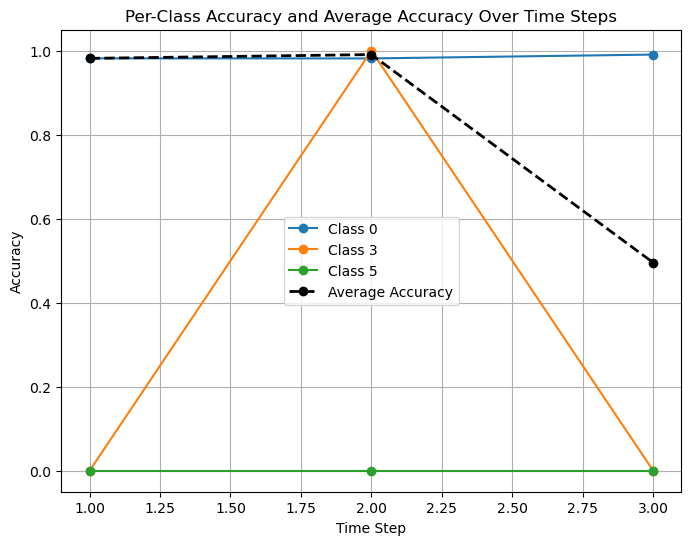

In [89]:
def plot_class_specific_accuracy_over_time(model_3d_numpy_array, folder_mapping, z_idx, configuration=0):
    # Extract confusion matrices for multiple steps
    multi_step_cm = model_3d_numpy_array[z_idx, 0, configuration]['confusion_matrices']  # List of confusion matrices

    # Convert the first confusion matrix to numpy array to get the number of classes
    n_classes = np.array(multi_step_cm[0]).shape[0]  # Number of classes

    # Initialize an array to store accuracy for each class at each step
    class_accuracies = np.zeros((n_classes, len(multi_step_cm)))
    
    # Initialize a mask to keep track of valid (non-zero) classes for averaging
    valid_class_mask = np.zeros((n_classes, len(multi_step_cm)), dtype=bool)

    # Iterate over the steps and calculate per-class accuracy
    for step, cm in enumerate(multi_step_cm):
        cm = np.array(cm)  # Convert to numpy array
        for i in range(n_classes):
            row_sum = np.sum(cm[i])  # Sum of the row for class i (true instances for class i)
            if row_sum > 0:
                class_accuracies[i, step] = cm[i, i] / row_sum  # Correct predictions / total true instances
                valid_class_mask[i, step] = True  # Mark class as valid for averaging

    # Calculate the average accuracy for each time step, ignoring invalid classes
    avg_accuracy = np.sum(class_accuracies * valid_class_mask, axis=0) / np.sum(valid_class_mask, axis=0)

    # Plot accuracy for each class over time
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        if np.any(valid_class_mask[i]):  # Only plot if the class has valid entries
            plt.plot(range(1, len(multi_step_cm) + 1), class_accuracies[i], marker='o', linestyle='-', label=f'Class {i}')
    
    # Plot the average accuracy
    plt.plot(range(1, len(multi_step_cm) + 1), avg_accuracy, marker='o', linestyle='--', color='black', label='Average Accuracy', linewidth=2)

    # Plot labels and title
    plt.xlabel('Time Step')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy and Average Accuracy Over Time Steps')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_class_specific_accuracy_over_time(model_3d_numpy_array, folder_mapping, z_idx)


In [127]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to generate lighter to medium shades of a base color
def generate_color_shades(base_color, num_shades):
    base_color = np.array(base_color)  # Convert base color to NumPy array
    color_shades = [(base_color * (0.5 + (i / (2 * num_shades)))).tolist() for i in range(num_shades)]  # Limit shading range
    return ['#%02x%02x%02x' % tuple(int(c) for c in shade) for shade in color_shades]

def plot_distribution_grouped_lstm_rf_with_palettes(model_3d_numpy_array, folder_mapping):
    # Define subgroups
    subgroups = {
        'balanced': [],
        'hybrid': [],
        'split': {},
        'unbalanced': []
    }

    # Assign folders to subgroups
    for folder, z_idx in folder_mapping.items():
        if 'unbalanced' in folder or 'without' in folder:
            subgroups['unbalanced'].append(z_idx)
        elif 'hybrid' in folder:
            subgroups['hybrid'].append(z_idx)
        elif 'split' in folder:
            metric_len = len(model_3d_numpy_array[z_idx, 0, 0]['confusion_matrices'][0])  # Length of confusion matrices
            if metric_len not in subgroups['split']:
                subgroups['split'][metric_len] = []
            subgroups['split'][metric_len].append(z_idx)
        elif 'balanced' in folder:
            subgroups['balanced'].append(z_idx)

    # Function to plot distribution for each subgroup and save the plot
    def plot_subgroup(z_indices, plot_title, group_name):
        plt.figure(figsize=(10, 6))

        num_folders = len(z_indices)
        
        # Generate lighter to medium shades for LSTM and RF
        lstm_cyan_shades = generate_color_shades([0, 255, 255], num_folders)  # Cyan shades for LSTM
        rf_magenta_shades = generate_color_shades([255, 0, 255], num_folders)  # Magenta shades for RF

        for i, z_idx in enumerate(z_indices):
            folder_name = list(folder_mapping.keys())[list(folder_mapping.values()).index(z_idx)]

            # LSTM Data
            multi_step_cm_lstm = model_3d_numpy_array[z_idx, 0, 0]['confusion_matrices']
            combined_cm_lstm = np.sum(np.array(multi_step_cm_lstm), axis=0)

            # Random Forest Data
            multi_step_cm_rf = model_3d_numpy_array[z_idx, 1, 0]['confusion_matrices']
            combined_cm_rf = np.sum(np.array(multi_step_cm_rf), axis=0)

            # Get the shape of the confusion matrix (both LSTM and RF have the same size)
            n_classes = combined_cm_lstm.shape[0]

            # Create arrays to hold the differences (predicted - actual)
            differences_lstm = []
            differences_rf = []

            # Loop through the confusion matrix to collect differences for both LSTM and RF
            for actual in range(n_classes):
                for pred in range(n_classes):
                    # LSTM differences
                    diff_lstm = pred - actual
                    count_lstm = combined_cm_lstm[actual, pred]
                    differences_lstm.extend([diff_lstm] * count_lstm)

                    # RF differences
                    diff_rf = pred - actual
                    count_rf = combined_cm_rf[actual, pred]
                    differences_rf.extend([diff_rf] * count_rf)

            # Calculate frequency of each difference for LSTM and RF
            unique_diffs_lstm, frequencies_lstm = np.unique(differences_lstm, return_counts=True)
            unique_diffs_rf, frequencies_rf = np.unique(differences_rf, return_counts=True)

            # Plot the frequency of the differences using line plots for LSTM and RF
            plt.plot(unique_diffs_lstm, frequencies_lstm, marker='o', linestyle='-', label=f'{folder_name} LSTM', color=lstm_cyan_shades[i])  # Cyan shades for LSTM
            plt.plot(unique_diffs_rf, frequencies_rf, marker='o', linestyle='--', label=f'{folder_name} RF', color=rf_magenta_shades[i])  # Magenta shades for RF

        # Labels and title
        plt.axvline(0, color='black', linestyle='--')  # Add vertical line at 0 for visual aid
        plt.xlabel('Prediction Difference (Pred - Actual)')
        plt.ylabel('Frequency')
        plt.title(plot_title)
        plt.grid(True)

        # Move the legend below the plot
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

        # Create the directory and save the plot
        save_dir = f'./plot/distribution/{group_name}'
        os.makedirs(save_dir, exist_ok=True)
        save_path = f'{save_dir}/{group_name}.png'
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()  # Close the plot to avoid display

    # Plot for Balanced, Hybrid, and Unbalanced subgroups
    for group_name in ['balanced', 'hybrid', 'unbalanced']:
        z_indices = subgroups[group_name]
        if z_indices:
            plot_subgroup(z_indices, f'Distribution of Prediction Differences (LSTM & RF) - {group_name.capitalize()} Folders', group_name)

    # Plot for Split (grouped by length of confusion matrix)
    for metric_len, z_indices in subgroups['split'].items():
        plot_subgroup(z_indices, f'Distribution of Prediction Differences (LSTM & RF) - Split Folders (Length: {metric_len})', f'split_len_{metric_len}')

# Example usage
plot_distribution_grouped_lstm_rf_with_palettes(model_3d_numpy_array, folder_mapping)


In [24]:
model_3d_numpy_array.shape

(20, 2, 3)

In [80]:
import pandas as pd
import numpy as np

def generate_single_step_metric_table(model_3d_array, folder_mapping):
    """
    Generates a table displaying metrics for LSTM and Random Forest models for single-step predictions,
    using the logic adapted from the plotting functions.
    
    Parameters:
    model_3d_array (numpy.ndarray): A 3D array where dimensions represent [folder, model (LSTM/RF), configuration].
    folder_mapping (dict): A dictionary mapping folder names to their corresponding indices in the 3D array.
    
    Returns:
    pandas.DataFrame: A DataFrame representing the table with metrics for each folder, filled using the adapted logic.
    """
    # Retrieve folder names and metrics from the provided list
    folder_names = list(folder_mapping.keys())
    metrics = ['accuracy', 'mse', 'rmse', 'mae', 'r2', 'precision', 'recall', 'f1']  # Metrics list
    
    # Initialize a DataFrame to hold the results
    columns = pd.MultiIndex.from_product([['LSTM', 'Random Forest'], metrics], names=['Model', 'Metric'])
    metric_table = pd.DataFrame(index=folder_names, columns=columns)
    
    # Configuration index for single-step prediction
    config_idx = 2  # Assuming single-step prediction corresponds to index 2
    
    # Populate the DataFrame with values from the 3D array using the same logic as the plotting functions
    for folder_name, folder_idx in folder_mapping.items():
        # LSTM metrics (index 0)
        for metric_name in metrics:
            try:
                # Access the metric value using the same pattern from the plotting functions
                lstm_value = model_3d_array[folder_idx, 0, config_idx][metric_name][0]
                metric_table.loc[folder_name, ('LSTM', metric_name)] = abs(round(lstm_value, 5))
            except (IndexError, TypeError, KeyError):
                metric_table.loc[folder_name, ('LSTM', metric_name)] = 0  # Default to 0 if an error occurs
        
        # Random Forest metrics (index 1)
        for metric_name in metrics:
            try:
                # Access the metric value using the same pattern from the plotting functions
                rf_value = model_3d_array[folder_idx, 1, config_idx][metric_name][0]
                metric_table.loc[folder_name, ('Random Forest', metric_name)] = abs(round(rf_value, 5))
            except (IndexError, TypeError, KeyError):
                metric_table.loc[folder_name, ('Random Forest', metric_name)] = 0  # Default to 0 if an error occurs
    
    return metric_table

# Example usage
# Assuming model_3d_array and folder_mapping are defined previously or loaded.
# The function will create a table for single-step predictions.
# single_step_metric_table = generate_single_step_metric_table_using_plot_logic(model_3d_array, folder_mapping)


In [81]:
generate_single_step_metric_table(model_3d_numpy_array, folder_mapping)

Model              LSTM                                     Random Forest      \
Metric         accuracy mse rmse mae r2 precision recall f1      accuracy mse   
balanced_10           0   0    0   0  0         0      0  0             0   0   
balanced_100          0   0    0   0  0         0      0  0             0   0   
balanced_150          0   0    0   0  0         0      0  0             0   0   
balanced_50           0   0    0   0  0         0      0  0             0   0   
hybrid_1              0   0    0   0  0         0      0  0             0   0   
hybrid_4              0   0    0   0  0         0      0  0             0   0   
hybrid_9              0   0    0   0  0         0      0  0             0   0   
split_12_12           0   0    0   0  0         0      0  0             0   0   
split_18_6            0   0    0   0  0         0      0  0             0   0   
split_6_6             0   0    0   0  0         0      0  0             0   0   
split_6_9             0   0    0   0  0         0      0  0             0   0   
split_9_3             0   0    0   0  0         0      0  0             0   0   
split_9_6             0   0    0   0  0         0      0  0             0   0   
unbalanced_10         0   0    0   0  0         0      0  0             0   0   
unbalanced_100        0   0    0   0  0         0      0  0             0   0   
unbalanced_25         0   0    0   0  0         0      0  0             0   0   
unbalanced_5          0   0    0   0  0         0      0  0             0   0   
unbalanced_50         0   0    0   0  0         0      0  0             0   0   
with                  0   0    0   0  0         0      0  0             0   0   
without               0   0    0   0  0         0      0  0             0   0   

Model                                           
Metric         rmse mae r2 precision recall f1  
balanced_10       0   0  0         0      0  0  
balanced_100      0   0  0         0      0  0  
balanced_150      0   0  0         0      0  0  
balanced_50       0   0  0         0      0  0  
hybrid_1          0   0  0         0      0  0  
hybrid_4          0   0  0         0      0  0  
hybrid_9          0   0  0         0      0  0  
split_12_12       0   0  0         0      0  0  
split_18_6        0   0  0         0      0  0  
split_6_6         0   0  0         0      0  0  
split_6_9         0   0  0         0      0  0  
split_9_3         0   0  0         0      0  0  
split_9_6         0   0  0         0      0  0  
unbalanced_10     0   0  0         0      0  0  
unbalanced_100    0   0  0         0      0  0  
unbalanced_25     0   0  0         0      0  0  
unbalanced_5      0   0  0         0      0  0  
unbalanced_50     0   0  0         0      0  0  
with              0   0  0         0      0  0  
without           0   0  0         0      0  0